# Experiment 1: All metrics / Default parameters / Synthetic data

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_syn')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 70


In [4]:
formal_names = {
    'FF-VUS': 'FF-VUS (L: 128)',
    'FF-VUS-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC': 'AUC',
    'VUS': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#eee13f',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'AFFILIATION': '#A5D1C2',        # Useless competitors
    'Range-AUC (L: 128)': '#547C6E',       # Useless competitors
    'RF': '#123327',                    # Useless competitors
}

In [61]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 370.50it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
33,syn_len_131072_n_10_avglen_10.npz,131072,10,10.0,AUC,0.779624,0.046382,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,syn_len_1073741824_n_10_avglen_10.npz,1073741824,10,10.0,Range-AUC (L: 128),0.151970,1299.979111,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,syn_len_100000_n_10_avglen_50.npz,100000,10,49.4,Range-AUC (L: 128),0.670851,0.139707,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
df = df[~df['Length'].isin([8192, 2147483648])].reset_index(drop=True)

## Analysis

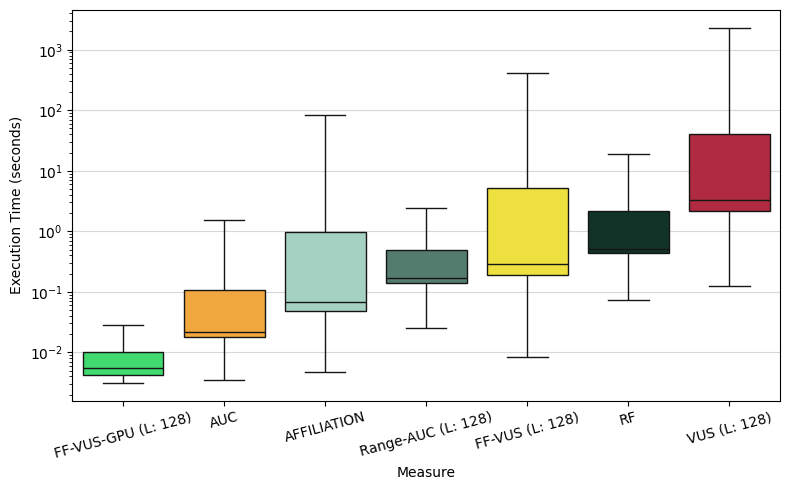

In [80]:
# TODO: Find why there is this big lines per metric, what affects this

# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    saturation=1,
    # showmeans=True, 
    # meanline=True
)
plt.grid(axis='y', alpha=.5)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

In [81]:
length_analysis_df = df[df['Length'] != 100_000]
n_anomalies_analysis_df = df[np.logical_and(df['Time series'].str.contains('len_100000_'), df['Time series'].str.contains('_avglen_10.npz'))]
avg_anomaly_length_analysis_df = df[df['Time series'].str.contains('len_100000_n_10_')]


--- Length Analysis ---
Total number of time series: 170
Total number of points: 21474672640, 21474672k, 21474m, 21b
Length -> min: 16384, max: 1073741824
Number of anomalies -> min: 9, max: 10
Anomalies average length -> min: 9.9, max: 10.333333333333334


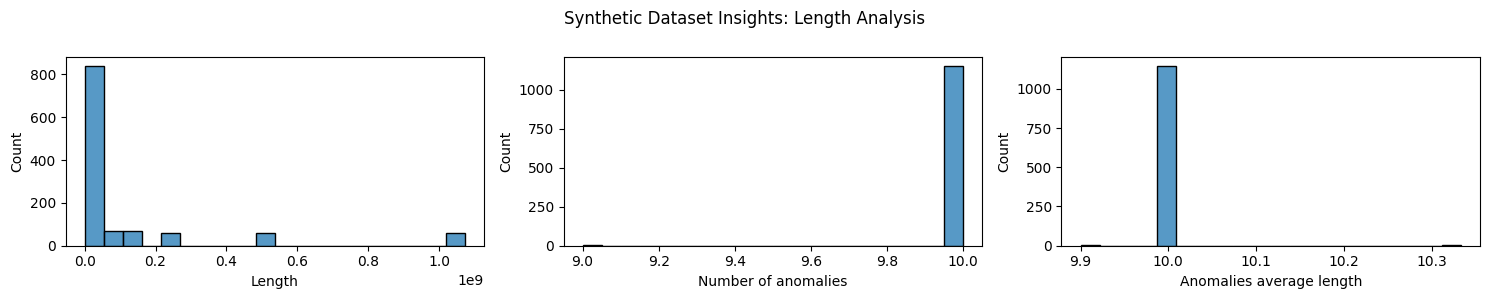


--- Number of Anomalies Analysis ---
Total number of time series: 150
Total number of points: 15000000, 15000k, 15m, 0b
Length -> min: 100000, max: 100000
Number of anomalies -> min: 1, max: 920
Anomalies average length -> min: 10.0, max: 10.5906288532676


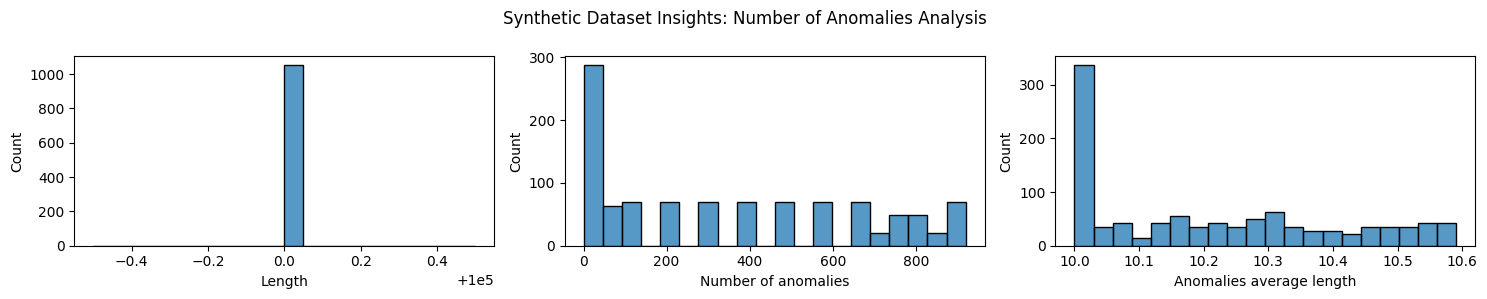


--- Average Anomaly Length Analysis ---
Total number of time series: 150
Total number of points: 15000000, 15000k, 15m, 0b
Length -> min: 100000, max: 100000
Number of anomalies -> min: 9, max: 10
Anomalies average length -> min: 1.0, max: 1050.88888888889


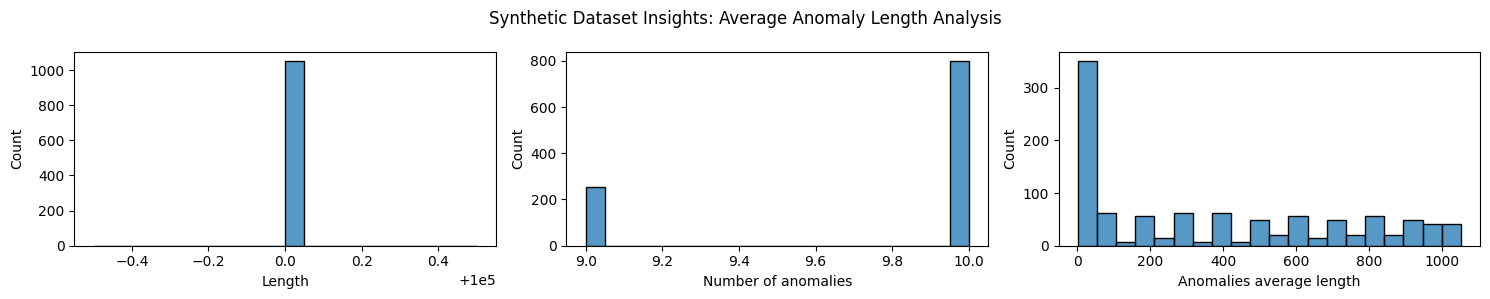

In [82]:
def plot_synthetic_insights(curr_df, group_name):
    """Plot synthetic dataset insights for a specific group."""
    print(f"\n--- {group_name} ---")
    metrics = curr_df['Metric'].unique()
    single_metric_df = curr_df[curr_df['Metric'] == metrics[0]]
    print(f"Total number of time series: {len(single_metric_df)}")
    print(f"Total number of points: {single_metric_df['Length'].sum()}, {single_metric_df['Length'].sum()//10**3}k, {single_metric_df['Length'].sum()//10**6}m, {single_metric_df['Length'].sum()//10**9}b")

    attributes = ["Length", "Number of anomalies", "Anomalies average length"]
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    bins = 20

    for attr, axis in zip(attributes, ax):
        print(f"{attr} -> min: {curr_df[attr].min()}, max: {curr_df[attr].max()}")
        sns.histplot(x=attr, data=curr_df, ax=axis, bins=bins)
        axis.set_xlabel(attr)

    plt.suptitle(f"Synthetic Dataset Insights: {group_name}")
    plt.tight_layout()
    plt.show()

plot_synthetic_insights(length_analysis_df, "Length Analysis")
plot_synthetic_insights(n_anomalies_analysis_df, "Number of Anomalies Analysis")
plot_synthetic_insights(avg_anomaly_length_analysis_df, "Average Anomaly Length Analysis")

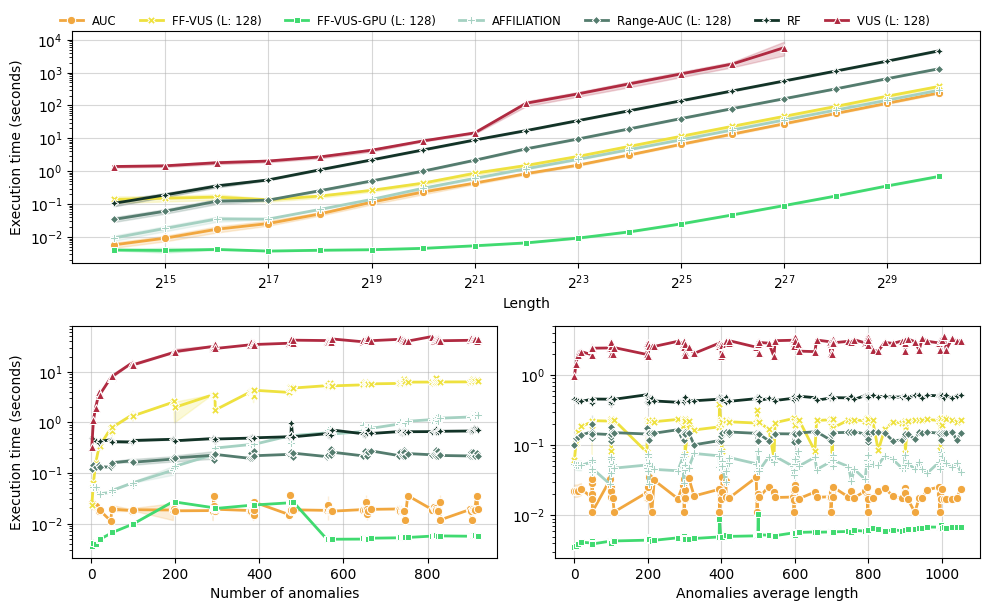

In [83]:
# TODO: Marker size increase
bins = 20
attr_control = {}
legend_axis = None
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
analysis_dfs = [length_analysis_df, n_anomalies_analysis_df, avg_anomaly_length_analysis_df]

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4),
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])
    curr_df = analysis_dfs[i]
    
    # Plot
    sns.lineplot(
        x=attribute,
        y='Metric time',
        hue='Metric',
        data=curr_df,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=2,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis
        axis.set_xscale('log', base=2)


handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

## Per step runtime analysis

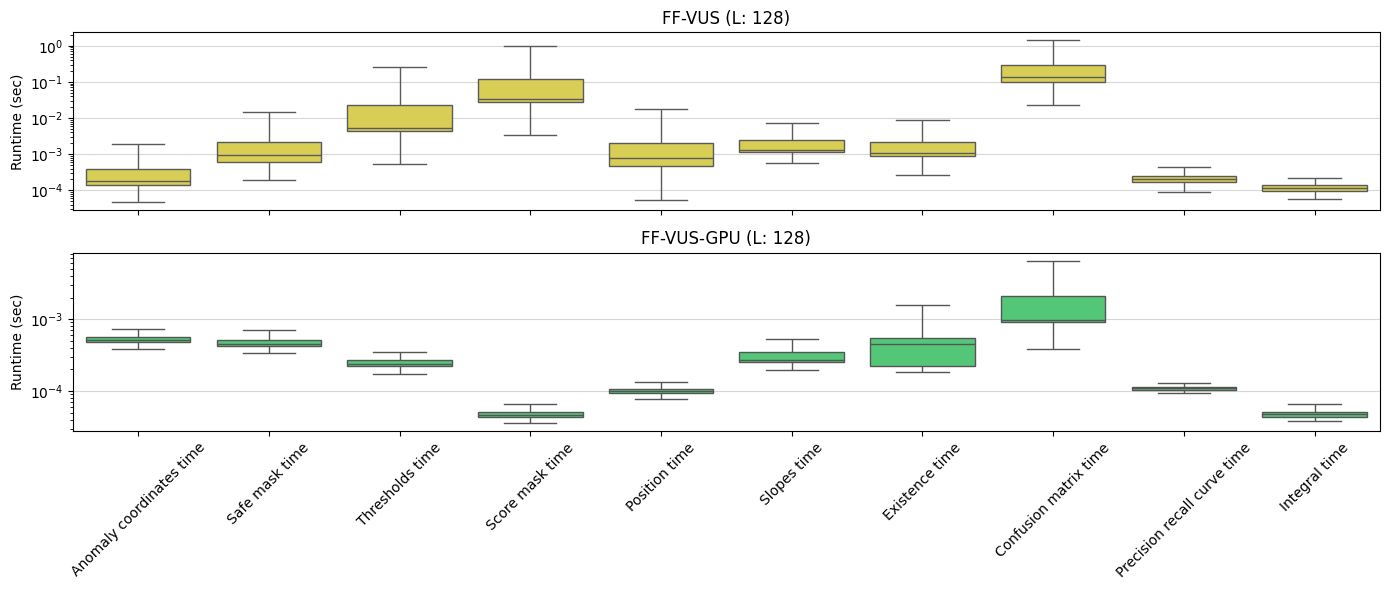

In [96]:
time_analysis_cols = [x for x in df.columns if 'time' in x and x != 'Metric time']
metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharey=False)

curr_df = df[df['Metric'].isin(metrics)]
for i, col in enumerate(time_analysis_cols):
    for j, axis in enumerate(ax):
        sns.boxplot(curr_df[curr_df['Metric'] == metrics[j]], ax=axis, x=i, y=col, log_scale=True, legend=(i == 0), color=color_palette[metrics[j]], showfliers=False)
        if j != 0:
            axis.set_xticks(np.arange(len(time_analysis_cols)), time_analysis_cols)
        else:
            axis.set_xticks(np.arange(len(time_analysis_cols)), [])
        axis.set_title(metrics[j])
        axis.set_ylabel('Runtime (sec)')
        axis.tick_params(axis='x', rotation=45)
        axis.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

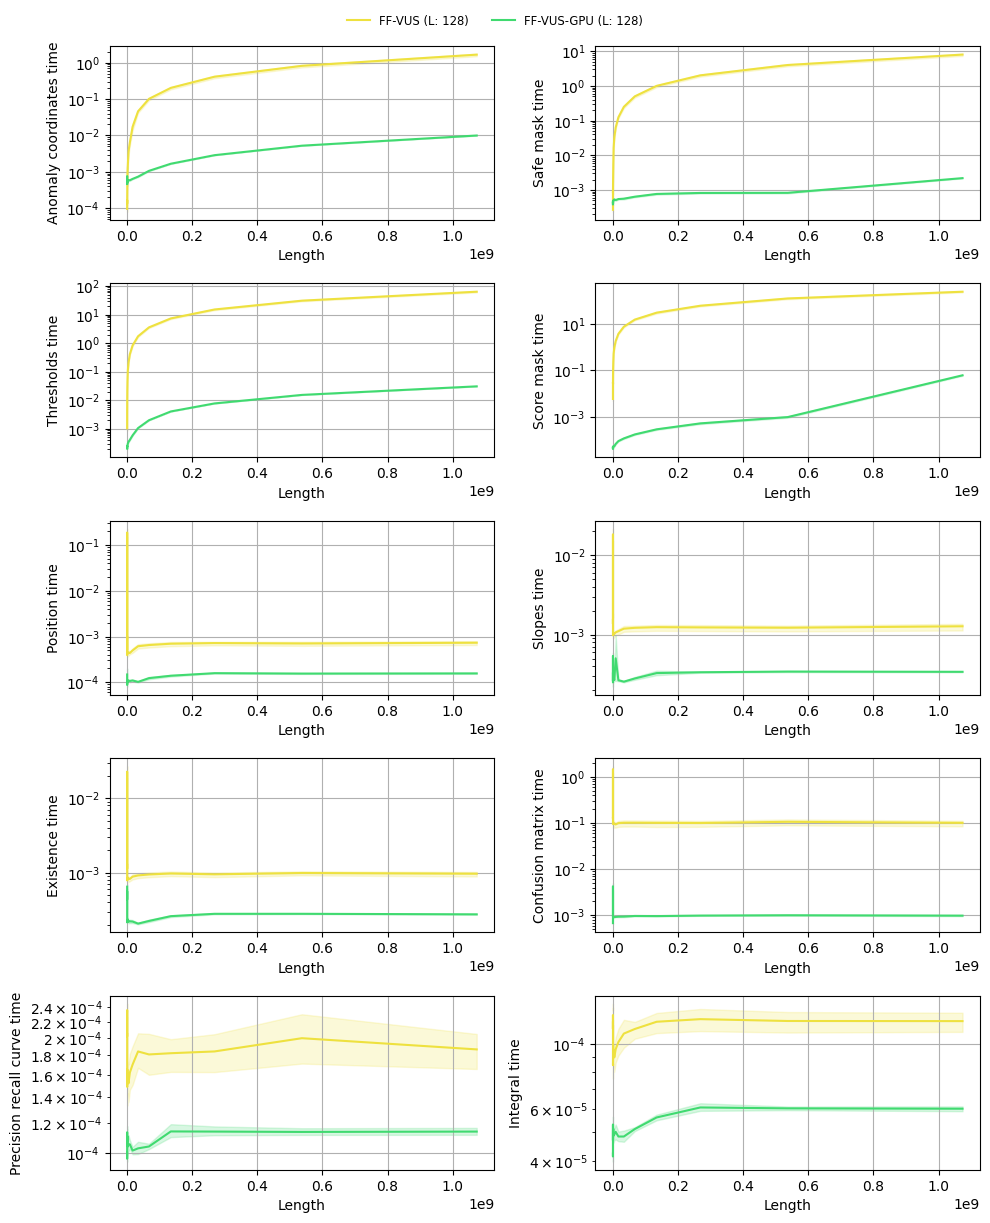

In [95]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

legend_axis = None
for col, axis in zip(time_analysis_cols, ax.flatten()):
    sns.lineplot(
        curr_df, 
        x='Length', 
        y=col, 
        hue='Metric', 
        ax=axis, 
        legend=(col == 'Anomaly coordinates time'), 
        palette=color_palette
    )
    axis.set_yscale('log')
    axis.grid()
    
    legend_axis = axis if legend_axis is None else legend_axis
    
handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.show()

## Error evaluation

In [19]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    syn_file_index = file[:6]
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0).reset_index()
    curr_df = curr_df.replace('syn_', syn_file_index, regex=True)
    df = pd.concat([df, curr_df], ignore_index=True)

df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|██████████████████████████████████████████| 70/70 [00:00<00:00, 327.38it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Metric,Metric value,Metric time,Slope size,Step,Global mask,...,Anomaly coordinates time,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time
3046,syn_8_len_131072_n_10_avglen_10.npz,131072,10,10.0,Range-AUC (L: 128),0.148627,0.117250,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2971,syn_5_len_100000_n_10_avglen_1.npz,100000,10,1.0,RF,0.021645,0.446965,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2592,syn_0_len_67108864_n_10_avglen_10.npz,67108864,10,10.0,VUS (L: 128),0.888001,2227.429639,128.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


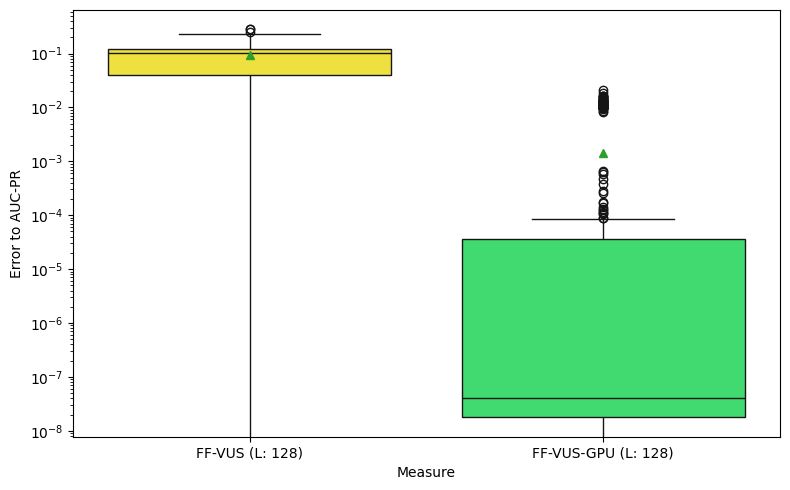

In [29]:
# What is the error between the difference metrics
current_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
vus_df = df[df['Metric'] == 'VUS (L: 128)'].set_index('Time series')
plt.figure(figsize=(8, 5))

values_df = df[df['Metric'].isin(current_metrics)][['Time series', 'Metric', 'Metric value']]
values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
values_df = values_df.loc[vus_df.index]
dif_df = values_df.apply(lambda row: row - vus_df.loc[row.name]['Metric value'], axis=1).abs()

sns.boxplot(dif_df, showfliers=True, palette=color_palette, saturation=1, showmeans=True)
# sns.violinplot(dif_df, palette=color_palette, saturation=1)
plt.xlabel('Measure')
plt.ylabel('Error to AUC-PR')
plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'error_to_aucpr.svg'))
plt.show()

In [30]:
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    dif_df[attr] = dif_df.apply(
        lambda row: df.loc[df['Time series'] == row.name, attr].values[0],
        axis=1
    )
dif_df

Metric,FF-VUS (L: 128),FF-VUS-GPU (L: 128),Length,Number of anomalies,Anomalies average length
Time series,,,,,
syn_6_len_8192_n_10_avglen_10.npz,2.114863e-02,6.016820e-08,8192,9,11.0
syn_6_len_16384_n_10_avglen_10.npz,2.903921e-02,2.032425e-08,16384,10,10.0
syn_6_len_32768_n_10_avglen_10.npz,1.975193e-01,8.244107e-05,32768,10,10.0
syn_6_len_65536_n_10_avglen_10.npz,1.854191e-01,3.346145e-08,65536,10,10.0
syn_6_len_100000_n_1_avglen_10.npz,7.771561e-16,5.639477e-08,100000,1,10.0
...,...,...,...,...,...
syn_8_len_8388608_n_10_avglen_10.npz,1.147180e-01,3.489784e-08,8388608,10,10.0
syn_8_len_16777216_n_10_avglen_10.npz,1.010170e-01,4.716874e-08,16777216,10,10.0
syn_8_len_33554432_n_10_avglen_10.npz,1.021223e-01,6.296268e-08,33554432,10,10.0


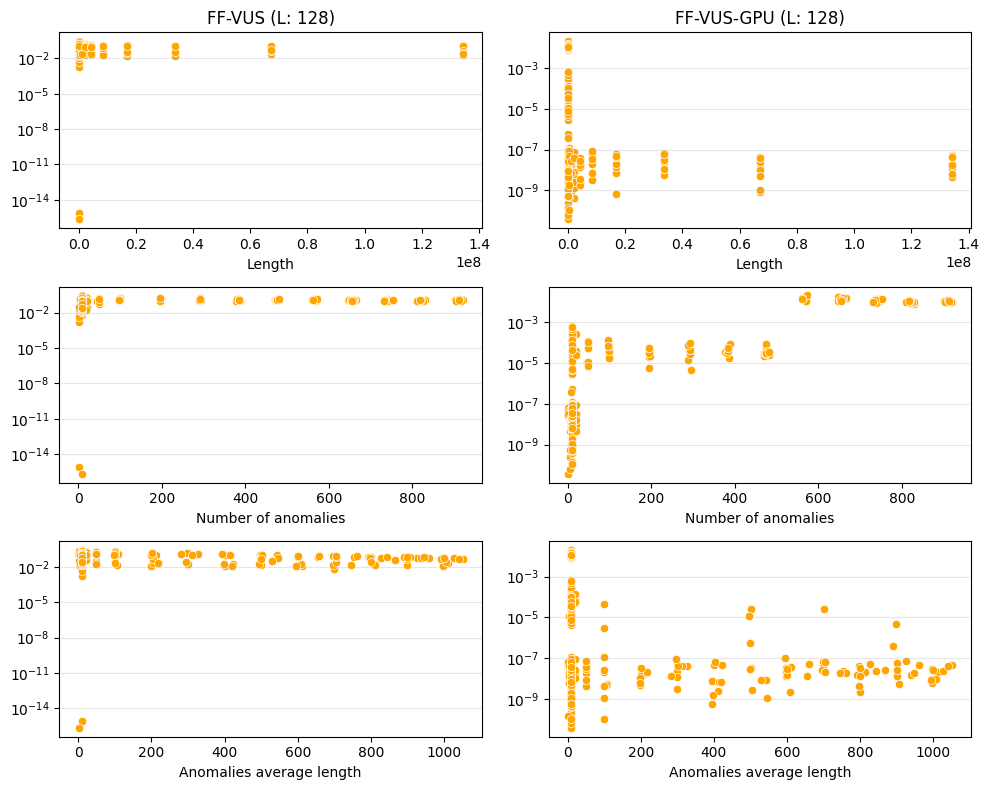

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(10, 8))
curr_metrics = ['FF-VUS (L: 128)', 'FF-VUS-GPU (L: 128)']
for i, attr in enumerate(attributes):
    for j, metric in enumerate(curr_metrics):
        sns.scatterplot(dif_df, y=metric, x=attr, ax=ax[i, j], color='orange')
        ax[i, j].set_yscale('log')
        ax[i, j].grid(axis='y', alpha=0.3)
        ax[i, j].set_ylabel('')
        if i == 0:
            ax[i, j].set_title(metric)
        

plt.tight_layout()
plt.show()